In [1]:
!pip install seaborn

In [ ]:
# -*- coding: utf-8 -*-
import pickle
import pandas as pd
from matplotlib import *
from matplotlib import pyplot as plt
import sys
import numpy as np
#load the pickle file as a dictionary
def loadDictionaryFromPickleFile(dictionaryPath):
    print("Loading dictionary at:", dictionaryPath)
    filePointer=open(dictionaryPath, 'rb')
    dictionary = pickle.load(filePointer)
    filePointer.close()
    print("The total number of keys in the dictionary are:", len(dictionary))
    return dictionary

#This function saves dictionaries as pickle files in the storage.
def saveDictionaryAsPickleFile(dictionary, dictionaryPath):
    filePointer=open(dictionaryPath, 'wb')
    pickle.dump(dictionary,filePointer, protocol=pickle.HIGHEST_PROTOCOL)
    filePointer.close()

def loadDictionaryFromPickleFileList(dictionaryPath):
    ''' Load the pickle file as a dictionary
    Args:
        dictionaryPath: path to the pickle file
    Return: dictionary from the pickle file
    '''
    filePointer=open(dictionaryPath, 'rb')
    dictionary = pickle.load(filePointer)
    filePointer.close()
    actual_dict = {}
    for curr_dict in dictionary:
        actual_dict[curr_dict['query_table']] = curr_dict['result_set']
    return actual_dict

which_benchmark_num = 0
while(which_benchmark_num!= 1 and which_benchmark_num != 2 and which_benchmark_num != 3 and which_benchmark_num != 4):
    #print("which benchmark? Press 1 for TUS, 2 for Labelled")
    print("which benchmark? Press 1 for TUS-Small, 2 for SANTOS-Small, 3 for BEN_X, 4 for BEN_Y")
    which_benchmark_num = int(input())
if which_benchmark_num == 1:
    #all_methods = ["d3l", 'turl', 'santos_full', 'santos_kb', 'santos_synth']
    all_methods = ["d3l", 'santos', 'starmie','starmie_vicuna_zero', 'starmie_vicuna_opt']
    which_benchmark = "tus"
    max_k = 60
    k_range = 5
elif which_benchmark_num == 2: #which_benchmark == 2
    #all_methods = ["d3l", 'santos_full', 'santos_kb', 'santos_synth']
    all_methods = ["d3l", 'santos', 'starmie','starmie_vicuna_zero', 'starmie_vicuna_opt']
    which_benchmark = "santos"
    max_k = 10
    k_range = 1
elif which_benchmark_num == 3:
    all_methods = ["d3l", 'santos', 'starmie','starmie_vicuna_zero', 'starmie_vicuna_opt']
    which_benchmark = "ben_x"
    max_k = 10
    k_range = 1
else:
    all_methods = ["d3l", 'santos', 'starmie','starmie_vicuna_zero', 'starmie_vicuna_opt']
    which_benchmark = "ben_y"
    max_k = 10
    k_range = 1

col_number = 3 

colors = {"d3l":"#e52638",
              "santos": "#68affc",
              "starmie":"#699f3c",
              "starmie_vicuna_zero": "#b04b3b",
              "starmie_vicuna_opt": "#ffa600"
              }
linestyles = {"d3l":"dashed",
              "santos": "solid",
              "starmie":"dotted",
              "starmie_vicuna_zero": "dashdot",
              "starmie_vicuna_opt": (0, (3, 1, 1, 1, 1, 1))
              }

labels = {"d3l":r"$D^{3}L$",
#           "turl": r"TURL",
          "santos": r"$SANTOS$",
          "starmie":r"$Starmie$",
          "starmie_vicuna_zero": r"$Starmie-Vicuna_{Zero}$",
          "starmie_vicuna_opt": r"$Starmie-Vicuna_{Optim}$"
          }

markers = {"d3l":"^",
           "santos": "s",
           "starmie":"o",
           "starmie_vicuna_zero": "*",
           "starmie_vicuna_opt": "+"
        }

precision_list_dict = {}
recall_list_dict = {}

query_mean_precision_list_dict = {}

total_ground_truth_size = 0
used_queries = 0
groundtruth = loadDictionaryFromPickleFile(r"groundtruth/"+which_benchmark+"UnionBenchmark.pickle")
#groundtruth = loadDictionaryFromPickleFile(r"groundtruth/validated_ugenv1_gt.pickle")

for table in groundtruth:
    #t28 tables have less than 60 results. So, skipping them in the analysis.
    #skipping t28, we have 125 query tables.
    if table.split("____",1)[0] != "t_28dc8f7610402ea7": 
        used_queries += 1
        total_ground_truth_size += len(groundtruth[table])
total_ground_truth_size = total_ground_truth_size / used_queries
while(max_k % k_range != 0):
    print("Enter k for mean average precision. 5 should be its factor:")
    max_k = int(input())
for which_method in all_methods:
    resPath = r"new_stats/"+which_benchmark+"_benchmark_result_by_"+which_method+".pickle"
    resultFile = loadDictionaryFromPickleFile(resPath)
    if type(resultFile) == list:
        resultFile = loadDictionaryFromPickleFileList(resPath)
    
    all_query_results = {}
    
    
    # =============================================================================
    # Test code for testing how many tp is received for each query table
    # =============================================================================
    each_tp_s = {}
    for table in resultFile:
        groundtruth_set = set(groundtruth[table])
        result_set = resultFile[table][:len(groundtruth_set)]
        find_intersection = set(result_set).intersection(groundtruth_set)
        each_tp_s[table] = (len(groundtruth_set), len(find_intersection))
        
    # =============================================================================
    # Precision and recall starts here
    # =============================================================================
    precision_array = []
    recall_array = []
    per_table_map_stats_precision = {}
    per_table_map_stats_recall = {}
    for k in range(1, max_k+1):
        true_positive = 0
        false_positive = 0
        false_negative = 0
        rec = 0
        for table in resultFile:
            if table.split("____",1)[0] != "t_28dc8f7610402ea7": 
                groundtruth_set = set(groundtruth[table])
                groundtruth_set = {x.split(".")[0] for x in groundtruth_set}
                result_set = resultFile[table][:k]
                result_set = [x.split(".")[0] for x in result_set]
                find_intersection = set(result_set).intersection(groundtruth_set)
                tp = len(find_intersection)
                #fp = k - tp
                if which_method == "starmie_gpt3" and k==10:
                    print("LENGTH OF RESULT SET", len(result_set))
                fp = k - tp
                fn = len(groundtruth_set) - tp
                if len(groundtruth_set)>=k: 
                    true_positive += tp
                    false_positive += fp
                    false_negative += fn
                query_table_name = table.split(".")[0].split('_')[0]
                curr_precision = 0.0
                if tp != 0 or fp != 0:
                    curr_precision = tp / (tp + fp)
                curr_recall = 0.0
                if tp != 0 or fn != 0:
                    curr_recall = tp / (tp+fn)
                if query_table_name not in per_table_map_stats_precision:
                    per_table_map_stats_precision[query_table_name] = [curr_precision]
                    per_table_map_stats_recall[query_table_name] = [curr_recall]
                else:
                    per_table_map_stats_precision[query_table_name].append(curr_precision)
                    per_table_map_stats_recall[query_table_name].append(curr_recall)
                rec += tp / (tp+fn)
                    
        precision = true_positive / (true_positive + false_positive)
        recall = rec/len(resultFile)
        precision_array.append(precision)
        recall_array.append(recall)
    
    used_k = [k_range]
    if max_k >k_range:
        for i in range(k_range * 2, max_k+1, k_range):
            used_k.append(i)
    print("--------------------------")
    for k in used_k:
        print("Precision at k = ",k,"=", precision_array[k-1])
        if which_method not in precision_list_dict:
            precision_list_dict[which_method] = [precision_array[k-1]]
        else:
            precision_list_dict[which_method].append(precision_array[k-1])
        
        print("Recall at k = ",k,"=", recall_array[k-1])
        if which_method not in recall_list_dict:
            recall_list_dict[which_method] = [recall_array[k-1]]
        else:
            recall_list_dict[which_method].append(recall_array[k-1])
        print("--------------------------")
#         for key, value in per_table_map_stats_precision.items():
#             print("QUERY TABLE", key)
#             print("Precision at query k = ",k,"=", value[k-1])
#             print("Recall at query k = ",k,"=", per_table_map_stats_recall[key][k-1])
#         print("--------------------------")
    map_sum = 0
    for k in range(0, max_k):
        map_sum += precision_array[k]
    mean_avg_pr = map_sum/max_k
    print("The mean average precision is:", mean_avg_pr)
    
    if which_method not in query_mean_precision_list_dict and which_benchmark == "ben_y":
        map_values = []
        
        for key, value in per_table_map_stats_precision.items():
            map_sum_query = 0
            for k in range(0, max_k):
                map_sum_query += value[k]
            mean_avg_pr_query = map_sum_query/max_k
            map_values.append((key,mean_avg_pr_query))
        
        query_mean_precision_list_dict[which_method] = map_values
        # Sort the list based on the 1-indexed values in descending order
        sorted_data = sorted(map_values, key=lambda x: x[1], reverse=True)

        # Get the top 5 highest values
        top_5_high_values = sorted_data[:5]
        bottom_5_values = sorted_data[-5:]

        print("TOP 5 HIGH VALUES", top_5_high_values)
        print("BOTTOM 5 VALUES", bottom_5_values)
        
#k = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
k = used_k
count = 0
fsize = 18
plt.figure(figsize=(6,5))

#ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
#plt.subplot(1, 2, 1)
plt.xticks(np.arange(0, max_k + k_range, k_range), fontsize=fsize)
plt.yticks(fontsize=fsize)
for which_method in precision_list_dict:
    plt.plot(k, precision_list_dict[which_method], color = colors[which_method], linestyle = linestyles[which_method], label = labels[which_method], marker=markers[which_method])
    count += 1
#plt.title("Precision")
plt.xlabel("k", fontsize=fsize)
plt.ylabel("P@k", fontsize=fsize)
#plt.xticks([0, 10, 2])
#plt.figtext(0.5, 0.01, "(a) Average Precision in TUS benchmark", wrap=True, horizontalalignment='center', fontsize=12)

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), borderaxespad=-0.05, fancybox=False, shadow=False, ncol=col_number, fontsize = fsize)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('precision_in_'+which_benchmark+'.pdf')
plt.show()
plt.clf()
plt.figure(figsize=(6,5))
#plt.subplot(1, 2,2)
plt.xticks(np.arange(0, max_k + k_range, k_range), fontsize=fsize)
plt.yticks(fontsize=fsize)
y_axis = []
for val in k:
    y_axis.append(val/total_ground_truth_size)

count = 0
for which_method in recall_list_dict:
    plt.plot(k, recall_list_dict[which_method], color = colors[which_method], linestyle = linestyles[which_method], label = labels[which_method], marker=markers[which_method])
    count += 1

#plt.title("Precision")

plt.xlabel("k", fontsize=fsize)
plt.ylabel("R@k", fontsize=fsize)
#plt.legend()
#plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.15), borderaxespad=-2, frameon = False, fontsize = fsize)
#plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.11), borderaxespad=-0.5, frameon = False, fontsize = fsize)
#plt.figtext(0.5, 0.01, "(b) Average Recall in TUS Benchmark", wrap=True, horizontalalignment='center', fontsize=12)
#plt.subplot(2, 2,3, colspan = 2)
#plt.legend(ncol=5, loc="upper center", bbox_to_anchor=(0, 0, 1, 1), frameon = False, fontsize = fsize)
#k /total_ground_truth_size
plt.plot(k, y_axis, color = "black", label = "IDEAL-Recall", linewidth = 2)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), borderaxespad=-0.05, fancybox=False, shadow=False, ncol=col_number, fontsize = fsize)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.ylim(top=0.6)
plt.savefig('recall_in_'+which_benchmark+'.pdf')  
plt.show()

plt.clf()
plt.figure(figsize=(14,5))
#plt.subplot(1, 2,2)
plt.xticks(np.arange(0, max_k + k_range, k_range), fontsize=fsize)
plt.yticks(fontsize=fsize)
y_axis = []
for val in k:
    y_axis.append(val/total_ground_truth_size)

count = 0
for which_method in recall_list_dict:
    plt.plot(k, recall_list_dict[which_method], color = colors[which_method], linestyle = linestyles[which_method], label = labels[which_method], marker=markers[which_method])
    count += 1

#plt.title("Precision")

plt.xlabel("k", fontsize=fsize)
plt.ylabel("R@k", fontsize=fsize)
#plt.legend()
#plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.15), borderaxespad=-2, frameon = False, fontsize = fsize)
#plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.11), borderaxespad=-0.5, frameon = False, fontsize = fsize)
#plt.figtext(0.5, 0.01, "(b) Average Recall in TUS Benchmark", wrap=True, horizontalalignment='center', fontsize=12)
#plt.subplot(2, 2,3, colspan = 2)
#plt.legend(ncol=5, loc="upper center", bbox_to_anchor=(0, 0, 1, 1), frameon = False, fontsize = fsize)
#k /total_ground_truth_size
plt.plot(k, y_axis, color = "black", label = "IDEAL-Recall", linewidth = 2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), borderaxespad=0.05, fancybox=False, shadow=False, ncol=col_number, fontsize = fsize)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('legend_'+which_benchmark+'.pdf', dpi=400)  
plt.show()

if which_benchmark == "ben_y":
    for which_method in all_methods:
        plt.clf()

        #plt.figure(figsize=(15, 5))
        # Separate x and y values from the list of tuples
        x_values, y_values = zip(*query_mean_precision_list_dict[which_method])
        x_ticks_positions = range(len(x_values))

        # Calculate the width of the bars (distance between consecutive x-tick positions)
    #     bar_width = 0.6
    #     # Calculate the appropriate figure size based on the number of bars
    #     figure_width = 50 * bar_width
    #     figure_height = 6  # You can adjust this value based on your preference
        print("Which method", which_method)
        # Set the appropriate figure size
        
        plt.figure(figsize=(2.5, 15))
        #plt.xticks(rotation='vertical')
        plt.rcParams.update({'font.size': 14})
        # Create the bar plot with equal spacing between bars
        #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), borderaxespad=-0.5, fancybox=False, shadow=False)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.barh(x_ticks_positions, y_values)
        # Set the x-tick positions and labels
        
        if which_method == 'd3l':
            # Add labels and title
            plt.yticks(x_ticks_positions, x_values)
            plt.ylabel('Topics')
            plt.xlabel('MAP@k')
        else:
            plt.xlabel('MAP@k')
            plt.yticks(x_ticks_positions, '')
        # Set the y-axis limits
        plt.xlim(0, 1)  # Add some padding for visualization
        #plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0.1)
        # Show the plot
        plt.margins(0.02)
        #plt.show()
        plt.savefig(f'legend_{which_method}_+query_specific.pdf', bbox_inches="tight")  

In [ ]:
###### CODE FOR CONFUSION MATRIX
import pickle
import pandas as pd
from matplotlib import *
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import numpy as np
#load the pickle file as a dictionary
def loadDictionaryFromPickleFile(dictionaryPath):
    print("Loading dictionary at:", dictionaryPath)
    filePointer=open(dictionaryPath, 'rb')
    dictionary = pickle.load(filePointer)
    filePointer.close()
    print("The total number of keys in the dictionary are:", len(dictionary))
    return dictionary

#This function saves dictionaries as pickle files in the storage.
def saveDictionaryAsPickleFile(dictionary, dictionaryPath):
    filePointer=open(dictionaryPath, 'wb')
    pickle.dump(dictionary,filePointer, protocol=pickle.HIGHEST_PROTOCOL)
    filePointer.close()

def loadDictionaryFromPickleFileList(dictionaryPath):
    ''' Load the pickle file as a dictionary
    Args:
        dictionaryPath: path to the pickle file
    Return: dictionary from the pickle file
    '''
    filePointer=open(dictionaryPath, 'rb')
    dictionary = pickle.load(filePointer)
    filePointer.close()
    actual_dict = {}
    for curr_dict in dictionary:
        actual_dict[curr_dict['query_table']] = curr_dict['result_set']
    return actual_dict

which_benchmark_num = 3
all_methods = ["d3l", 'santos', 'starmie','starmie_vicuna_zero', 'starmie_vicuna_opt']
which_benchmark = "ben_y"
max_k = 10
k_range = 1

col_number = 3 

colors = {"d3l":"#e52638",
              "santos": "#68affc",
              "starmie":"#699f3c",
              "starmie_vicuna_zero": "#b04b3b",
              "starmie_vicuna_opt": "#ffa600"
              }
linestyles = {"d3l":"dashed",
              "santos": "solid",
              "starmie":"dotted",
              "starmie_vicuna_zero": "dashdot",
              "starmie_vicuna_opt": (0, (3, 1, 1, 1, 1, 1))
              }

labels = {"d3l":r"$D^{3}L$",
#           "turl": r"TURL",
          "santos": r"$SANTOS$",
          "starmie":r"$Starmie$",
          "starmie_vicuna_zero": r"$Starmie-Vicuna_{Zero}$",
          "starmie_vicuna_opt": r"$Starmie-Vicuna_{Optim}$"
          }

markers = {"d3l":"^",
           "santos": "s",
           "starmie":"o",
           "starmie_vicuna_zero": "*",
           "starmie_vicuna_opt": "+"
        }

precision_list_dict = {}
recall_list_dict = {}

query_mean_precision_list_dict = {}

total_ground_truth_size = 0
used_queries = 0
groundtruth = pd.read_csv(r"groundtruth/"+which_benchmark+"_groundtruth.csv")

tp_list = []
fp_list = []
tn_list = []
fn_list = []

for which_method in all_methods:
    curr_tp = 0
    curr_fp = 0
    curr_tn = 0
    curr_fn = 0
    resPath = r"new_stats/"+which_benchmark+"_benchmark_result_by_"+which_method+".pickle"
    resultFile = loadDictionaryFromPickleFile(resPath)
    if type(resultFile) == list:
        resultFile = loadDictionaryFromPickleFileList(resPath)

    all_query_results = {}

    for _,row in groundtruth.iterrows():
        curr_query_table = row['query_table']
        curr_data_lake_table = row['data_lake_table']
        is_unionable = True if int(row['unionable']) == 1 else False
        result_unionable = False
        curr_result_set = resultFile[curr_query_table]
        if len(curr_result_set) > 1:
            if not curr_result_set[0].endswith('.csv'):
                curr_data_lake_table = curr_data_lake_table.split('.')[0]
        if curr_data_lake_table in curr_result_set:
            result_unionable = True
        if result_unionable == is_unionable:
            if is_unionable:
                curr_tp += 1
            else:
                curr_tn += 1
        else:
            if is_unionable:
                curr_fn += 1
            else:
                curr_fp += 1
    print(f"Currently at {which_method}")
    accuracy = float(curr_tp + curr_tn) / (curr_tp + curr_tn + curr_fp + curr_fn)
    print("Accuracy", accuracy)
    corner_case = float(curr_fp + curr_fn) / (curr_tp + curr_tn + curr_fp + curr_fn)
    print("Corner Case Ratio", corner_case)    
    plt.clf()
    cm = np.array([[curr_tp, curr_fn],
                   [curr_fp, curr_tn]])
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.light_palette("navy", 12), xticklabels=['Unionable', 'Non-Unionable'], yticklabels=['Unionable', 'Non-Unionable'], vmin=50, vmax=450)
    plt.rcParams.update({'font.size': 18})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    
    plt.savefig(f'cm_{which_method}.pdf')
    plt.show()
    #plot_confusion_matrix(curr_tp, curr_fp, curr_tn, curr_fn)

#     print(curr_fp)
#     print(curr_tn)
#     print(curr_fn)

        

which ablation? Press 1 for ICL, 2 for Sparsity


 2


Loading dictionary at: groundtruth/ben_yUnionBenchmark.pickle
The total number of keys in the dictionary are: 50
Loading dictionary at: new_stats/ben_y_benchmark_result_by_d3l_sparse_0.pickle
The total number of keys in the dictionary are: 50
--------------------------
Precision at k =  10 = 0.126
Recall at k =  10 = 0.12599999999999997
--------------------------
MAP 0.14787380952380952
Loading dictionary at: new_stats/ben_y_benchmark_result_by_d3l_sparse_5.pickle
The total number of keys in the dictionary are: 50
--------------------------
Precision at k =  10 = 0.106
Recall at k =  10 = 0.106
--------------------------
MAP 0.13641349206349207
Loading dictionary at: new_stats/ben_y_benchmark_result_by_d3l_sparse_10.pickle
The total number of keys in the dictionary are: 50
--------------------------
Precision at k =  10 = 0.118
Recall at k =  10 = 0.118
--------------------------
MAP 0.17630714285714286
Loading dictionary at: new_stats/ben_y_benchmark_result_by_d3l_sparse_15.pickle
The

<Figure size 600x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

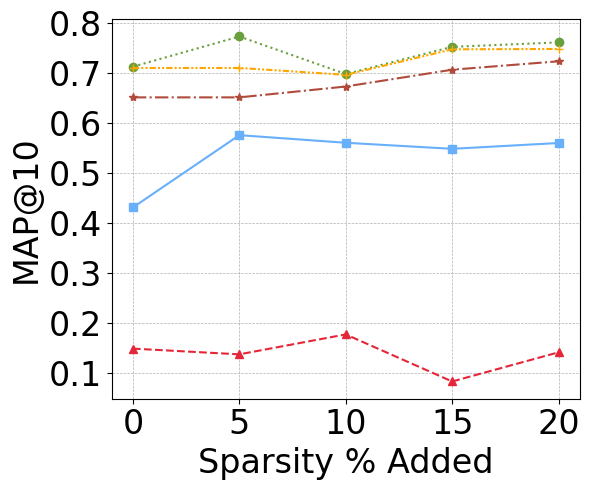

In [2]:
# -*- coding: utf-8 -*-
import pickle
import pandas as pd
from matplotlib import *
from matplotlib import pyplot as plt
import sys
import numpy as np
#load the pickle file as a dictionary
def loadDictionaryFromPickleFile(dictionaryPath):
    print("Loading dictionary at:", dictionaryPath)
    filePointer=open(dictionaryPath, 'rb')
    dictionary = pickle.load(filePointer)
    filePointer.close()
    print("The total number of keys in the dictionary are:", len(dictionary))
    return dictionary

#This function saves dictionaries as pickle files in the storage.
def saveDictionaryAsPickleFile(dictionary, dictionaryPath):
    filePointer=open(dictionaryPath, 'wb')
    pickle.dump(dictionary,filePointer, protocol=pickle.HIGHEST_PROTOCOL)
    filePointer.close()

def loadDictionaryFromPickleFileList(dictionaryPath):
    ''' Load the pickle file as a dictionary
    Args:
        dictionaryPath: path to the pickle file
    Return: dictionary from the pickle file
    '''
    filePointer=open(dictionaryPath, 'rb')
    dictionary = pickle.load(filePointer)
    filePointer.close()
    actual_dict = {}
    for curr_dict in dictionary:
        actual_dict[curr_dict['query_table']] = curr_dict['result_set']
    return actual_dict

which_ablation_num = 0
which_ablation = ""
while(which_ablation_num!= 1 and which_ablation_num != 2):
    #print("which benchmark? Press 1 for TUS, 2 for Labelled")
    print("which ablation? Press 1 for ICL, 2 for Sparsity")
    which_ablation_num = int(input())
if which_ablation_num == 1:
    #all_methods = ["d3l", 'turl', 'santos_full', 'santos_kb', 'santos_synth']
    all_methods = ["starmie_gpt2xl",'starmie_alpaca','starmie_vicuna']
    which_benchmark = "ben_y"
    which_ablation = "icl"
    max_k = 10
    k_range = 1
else: #which_benchmark == 2
    #all_methods = ["d3l", 'santos_full', 'santos_kb', 'santos_synth']
    all_methods = ["d3l", 'santos', 'starmie','starmie_vicuna_zero', 'starmie_vicuna_opt']
    which_benchmark = "ben_y"
    which_ablation = "sparse"
    max_k = 10
    k_range = 1

col_number = 3 

colors = {"d3l":"#e52638",
              "santos": "#68affc",
              "starmie":"#699f3c",
              "starmie_vicuna_zero": "#b04b3b",
              "starmie_vicuna_opt": "#ffa600"
              }
if which_ablation_num == 1:
    colors = {"starmie_gpt2xl": "#b04b3b",
              "starmie_gpt3": "#68affc",
              "starmie_alpaca":"#699f3c",
              "starmie_vicuna":"#e52638",
              }
    
    
linestyles = {"d3l":"dashed",
              "santos": "solid",
              "starmie":"dotted",
              "starmie_vicuna_zero": "dashdot",
              "starmie_vicuna_opt": (0, (3, 1, 1, 1, 1, 1))
              }
if which_ablation_num == 1:
    linestyles = {"starmie_gpt2xl":"dashed",
                  "starmie_gpt3": "solid",
                  "starmie_alpaca":"dotted",
                  "starmie_vicuna": "dashdot"
                  }

labels = {"d3l":r"$D^{3}L$",
#           "turl": r"TURL",
          "santos": r"$SANTOS$",
          "starmie":r"$Starmie$",
          "starmie_vicuna_zero": r"$Starmie-Vicuna_{Zero}$",
          "starmie_vicuna_opt": r"$Starmie-Vicuna_{Optim}$"
          }
if which_ablation_num == 1:
    labels = {"starmie_gpt2xl":r"Starmie-GPT2XL",
              "starmie_gpt3": r"Starmie-GPT3",
              "starmie_alpaca":r"Starmie-Alpaca",
              "starmie_vicuna": r"Starmie-Vicuna"
              }    

markers = {"d3l":"^",
           "santos": "s",
           "starmie":"o",
           "starmie_vicuna_zero": "*",
           "starmie_vicuna_opt": "+"
        }
if which_ablation_num == 1:
    markers = {"starmie_gpt2xl":"^",
               "starmie_gpt3": "s",
               "starmie_alpaca":"o",
               "starmie_vicuna": "*"
            }
    
precision_list_dict = {}
recall_list_dict = {}
mean_precision_list_dict = {}
ablation_val_list = []
total_ground_truth_size = 0
used_queries = 0
groundtruth = loadDictionaryFromPickleFile(r"groundtruth/"+which_benchmark+"UnionBenchmark.pickle")

for table in groundtruth:
    #t28 tables have less than 60 results. So, skipping them in the analysis.
    #skipping t28, we have 125 query tables.
    if table.split("____",1)[0] != "t_28dc8f7610402ea7": 
        used_queries += 1
        total_ground_truth_size += len(groundtruth[table])
total_ground_truth_size = total_ground_truth_size / used_queries
while(max_k % k_range != 0):
    print("Enter k for mean average precision. 5 should be its factor:")
    max_k = int(input())

if which_ablation == "icl":
    ablation_val_list = [0,1,2,3]
else:
    ablation_val_list = [0,5,10,15,20]
for which_method in all_methods:
    for curr_ablation in ablation_val_list:
        resPath = f"new_stats/{which_benchmark}_benchmark_result_by_{which_method}_{which_ablation}_{curr_ablation}.pickle"
        resultFile = loadDictionaryFromPickleFile(resPath)
        if type(resultFile) == list:
            resultFile = loadDictionaryFromPickleFileList(resPath)
        all_query_results = {}


        # =============================================================================
        # Test code for testing how many tp is received for each query table
        # =============================================================================
        each_tp_s = {}
        for table in resultFile:
            groundtruth_set = set(groundtruth[table])
            result_set = resultFile[table][:len(groundtruth_set)]
            find_intersection = set(result_set).intersection(groundtruth_set)
            each_tp_s[table] = (len(groundtruth_set), len(find_intersection))

        # =============================================================================
        # Precision and recall starts here
        # =============================================================================
        precision_array = []
        recall_array = []
        for k in range(1, max_k+1):
            true_positive = 0
            false_positive = 0
            false_negative = 0
            rec = 0
            for table in resultFile:
                if table.split("____",1)[0] != "t_28dc8f7610402ea7": 
                    groundtruth_set = set(groundtruth[table])
                    groundtruth_set = {x.split(".")[0] for x in groundtruth_set}
                    result_set = resultFile[table][:k]
                    result_set = [x.split(".")[0] for x in result_set]
                    find_intersection = set(result_set).intersection(groundtruth_set)
                    tp = len(find_intersection)
                    fp = k - tp
                    fn = len(groundtruth_set) - tp
                    if len(groundtruth_set)>=k: 
                        true_positive += tp
                        false_positive += fp
                        false_negative += fn
                    query_table_name = table.split(".")[0].split('_')[0]
                    curr_precision = 0.0
                    if tp != 0 or fp != 0:
                        curr_precision = tp / (tp + fp)
                    curr_recall = 0.0
                    if tp != 0 or fn != 0:
                        curr_recall = tp / (tp+fn)
                    rec += tp / (tp+fn)

            precision = true_positive / (true_positive + false_positive)
            recall = rec/len(resultFile)
            precision_array.append(precision)
            recall_array.append(recall)

        used_k = [k_range]
        if max_k >k_range:
            for i in range(k_range * 2, max_k+1, k_range):
                used_k.append(i)
        print("--------------------------")
        print("Precision at k = ",max_k,"=", precision_array[max_k-1])
        if which_method not in precision_list_dict:
            precision_list_dict[which_method] = [precision_array[max_k-1]]
        else:
            precision_list_dict[which_method].append(precision_array[k-1])

        print("Recall at k = ",max_k,"=", recall_array[max_k-1])
        if which_method not in recall_list_dict:
            recall_list_dict[which_method] = [recall_array[max_k-1]]
        else:
            recall_list_dict[which_method].append(recall_array[max_k-1])
        print("--------------------------")
    #         for key, value in per_table_map_stats_precision.items():
    #             print("QUERY TABLE", key)
    #             print("Precision at query k = ",k,"=", value[k-1])
    #             print("Recall at query k = ",k,"=", per_table_map_stats_recall[key][k-1])
    #         print("--------------------------")
        map_sum = 0
        for k in range(0, max_k):
            map_sum += precision_array[k]
        mean_avg_pr = map_sum/max_k
        print("MAP", mean_avg_pr)
        if which_method not in mean_precision_list_dict:
            mean_precision_list_dict[which_method] = [mean_avg_pr]
        else:
            mean_precision_list_dict[which_method].append(mean_avg_pr)
        

k = ablation_val_list
count = 0
fsize = 24
plt.figure(figsize=(6,5))

#ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
#plt.subplot(1, 2, 1)

k_range = 1 if which_ablation == "icl" else 5
plt.xticks(ablation_val_list, fontsize=fsize)
plt.yticks(fontsize=fsize)
for which_method in precision_list_dict:
    print(precision_list_dict[which_method])
    plt.plot(k, precision_list_dict[which_method], color = colors[which_method], linestyle = linestyles[which_method], label = labels[which_method], marker=markers[which_method])
    count += 1
#plt.title("Precision")
xlabel = ""
if which_ablation == "icl":
    xlabel = "# ICL Examples"
else:
    xlabel = "Sparsity % Added"
plt.xlabel(xlabel, fontsize=fsize)
plt.ylabel("P@10", fontsize=fsize)
#plt.xticks([0, 10, 2])
#plt.figtext(0.5, 0.01, "(a) Average Precision in TUS benchmark", wrap=True, horizontalalignment='center', fontsize=12)

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), borderaxespad=-0.05, fancybox=False, shadow=False, ncol=col_number, fontsize = fsize)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.savefig(f'precision_{which_ablation}_in_'+which_benchmark+'.pdf')
#plt.ylim(0.1,)
#plt.show()

####################################################################

plt.clf()
plt.figure(figsize=(20,20))
plt.xticks(ablation_val_list, fontsize=fsize)
plt.yticks(fontsize=fsize)
for which_method in mean_precision_list_dict:
    plt.plot(k, mean_precision_list_dict[which_method], color = colors[which_method], linestyle = linestyles[which_method], label = labels[which_method], marker=markers[which_method])
    count += 1
#plt.title("Precision")
xlabel = ""
if which_ablation == "icl":
    xlabel = "# ICL Examples"
else:
    xlabel = "Sparsity % Added"
plt.xlabel(xlabel, fontsize=fsize)
plt.ylabel("MAP@10", fontsize=fsize)
#plt.ylim(0.1,)
#plt.xticks([0, 10, 2])
#plt.figtext(0.5, 0.01, "(a) Average Precision in TUS benchmark", wrap=True, horizontalalignment='center', fontsize=12)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), borderaxespad=-0.05, fancybox=False, shadow=False, ncol=col_number, fontsize = fsize)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.savefig(f'legend_{which_ablation}_in_'+which_benchmark+'.pdf')
#plt.show()

####################################################################

plt.clf()
plt.figure(figsize=(6,5))
plt.xticks(ablation_val_list, fontsize=fsize)
plt.yticks(fontsize=fsize)
for which_method in mean_precision_list_dict:
    plt.plot(k, mean_precision_list_dict[which_method], color = colors[which_method], linestyle = linestyles[which_method], label = labels[which_method], marker=markers[which_method])
    count += 1
#plt.title("Precision")
xlabel = ""
if which_ablation == "icl":
    xlabel = "# ICL Examples"
else:
    xlabel = "Sparsity % Added"
plt.xlabel(xlabel, fontsize=fsize)
plt.ylabel("MAP@10", fontsize=fsize)
#plt.ylim(0.1,)
#plt.xticks([0, 10, 2])
#plt.figtext(0.5, 0.01, "(a) Average Precision in TUS benchmark", wrap=True, horizontalalignment='center', fontsize=12)

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), borderaxespad=-0.05, fancybox=False, shadow=False, ncol=col_number, fontsize = fsize)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.savefig(f'MAP_{which_ablation}_in_'+which_benchmark+'.pdf')
#plt.show()




